# training_templateのノートブック

In [2]:
!pip install torch==1.6.0
!pip install zarr
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 4.2 MB/s 
     |████████████████████████████████| 94 kB 8.2 MB/s 
     |████████████████████████████████| 6.0 MB 38.9 MB/s 
     |████████████████████████████████| 145 kB 21.8 MB/s 
     |████████████████████████████████| 40 kB 9.0 MB/s 
     |████████████████████████████████| 1.1 MB 75.7 MB/s 
     |████████████████████████████████| 77 kB 15.8 MB/s 
     |████████████████████████████████| 159 kB 75.6 MB/s 
     |████████████████████████████████| 326 kB 66.4 MB/s 
     |████████████████████████████████| 53 kB 7.1 MB/s 
   

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os, gc
os.environ["L5KIT_DATA_FOLDER"] = '/home/knikaido/work/Lyft/data/lyft-motion-prediction-autonomous-vehicles'
import zarr
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
import time
import cloudpickle
import requests
import mlflow
import yaml
from typing import Dict

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet34
from torch import Tensor


from l5kit.data import PERCEPTION_LABELS
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
!pip freeze | grep l5kit

l5kit @ file:///home/knikaido/work/Lyft/Git/external/l5kitorigin/l5kit
l5kitcustom @ file:///home/knikaido/work/Lyft/Git/external/l5kitcustom/l5kit


In [3]:
DEBUG = False

common_cfg = {
    'seed': 500,
    'output_dir': './outputs/1025/',
    'epoch': 2,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 500,
    'train_max': 12,
    'learning_rate': 1e-3
}


# training cfg
training_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [400, 400], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'train_data_loader': {
        'key': "scenes/train.zarr",
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 0
    },

    ## Train params
    'train_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 10000
    }
}


# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [400, 400], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate.zarr",
        'batch_size': 2,
        'shuffle': True,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

# # inference cfg
# inference_cfg = {
    
#     'format_version': 4,
#     'model_params': {
#         'history_num_frames': 10,
#         'history_step_size': 1,
#         'history_delta_time': 0.1,
#         'future_num_frames': 50,
#         'future_step_size': 1,
#         'future_delta_time': 0.1
#     },
    
#     'raster_params': {
#         'raster_size': [448, 448],
#         'pixel_size': [0.5, 0.5],
#         'ego_center': [0.25, 0.5],
#         'map_type': 'py_semantic',
#         'satellite_map_key': 'aerial_map/aerial_map.png',
#         'semantic_map_key': 'semantic_map/semantic_map.pb',
#         'dataset_meta_key': 'meta.json',
#         'filter_agents_threshold': 0.5
#     },
    
#         'test_data_loader': {
#         'key': 'scenes/test.zarr',
#         'batch_size': 16,
#         'shuffle': False,
#         'num_workers': 0
#     }

# }

In [4]:
if DEBUG==False:
    mlflow.start_run(run_name='1025.ipynb')

In [5]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'
SAMPLE_ZARR = DATA_DIR / 'scenes/sample.zarr'

# cfg = load_config_data(str(INPUT_ROOT / "lyft-config-files/visualisation_config.yaml"))

In [6]:
def set_seed(seed: int = 42):
#     random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
#     torch.backends.cudnn.deterministic = True  # type: ignore
#     torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(common_cfg['seed'])

In [7]:
# root directory
# DIR_INPUT = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

#submission
SINGLE_MODE_SUBMISSION = f"{DATA_DIR}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DATA_DIR}/multi_mode_sample_submission.csv"

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = str(DATA_DIR)
dm = LocalDataManager(None)
print(training_cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet34', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [400, 400], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 0}, 'train_params': {'checkpoint_every_n_steps': 5000, 'max_num_steps': 10000}}


In [8]:
train_mask = np.load(f"{DATA_DIR}/scenes/mask.npz")

In [9]:
train_mask["arr_0"].shape

(88594921,)

In [10]:
# training cfg
train_cfg = training_cfg["train_data_loader"]

# rasterizer
rasterizer = build_rasterizer(training_cfg, dm)

# dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_mask = np.load(f"{DATA_DIR}/scenes/mask.npz")["arr_0"]
train_dataset = AgentDataset(training_cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [11]:
# validation cfg
valid_cfg = validation_cfg["valid_data_loader"]

# rasterizer
rasterizer = build_rasterizer(validation_cfg, dm)

# dataloader
valid_zarr = ChunkedDataset(dm.require(valid_cfg["key"])).open()
valid_dataset = AgentDataset(validation_cfg, valid_zarr, rasterizer)
valid_dataloader = DataLoader(valid_dataset, shuffle=valid_cfg["shuffle"], batch_size=valid_cfg["batch_size"], 
                             num_workers=valid_cfg["num_workers"])
print(valid_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## loss

In [12]:
def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

In [13]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        # TODO: support other than resnet18?
        backbone = resnet34(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        backbone_out_features = 512

        # X, Y coords for the future positions (output shape: Bx50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (bs)x(modes)x(time)x(2D coords)
        # confidences (bs)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [14]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds

In [15]:
# compiling model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(training_cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=common_cfg['learning_rate'])
criterion = nn.MSELoss(reduction="none")
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.99999)

In [16]:
for batch_idx, data in enumerate(train_dataloader):
    
    break

/home/user/.local/lib/python3.6/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


In [17]:
data['image'].shape

torch.Size([32, 25, 400, 400])

In [18]:
len(train_dataloader)

703023

In [19]:
if DEBUG==False:
    common_cfg['train_max'] = len(train_dataloader)

In [20]:
def save_model(model):
    torch.save(model.state_dict(), OUTPUT_DIR + 'model')
    if DEBUG==False:
        mlflow.log_artifact( OUTPUT_DIR + 'model')   

In [21]:
def log(message):
    print(message)
    with open(OUTPUT_DIR + 'log.txt', 'a+') as logger:
        logger.write(f'{message}\n')
    if DEBUG==False:
        mlflow.log_artifact( OUTPUT_DIR + 'log.txt')  

In [22]:
def plot_loss(t_loss, v_loss):
    fig = plt.figure(figsize=(4,3), dpi= 80)
    plt.title('loss')
    plt.plot(t_loss, color='tab:red', label='train', marker='x')
    plt.plot(v_loss, color='tab:blue', label='valid', marker='x')
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.legend()
    fig.savefig(OUTPUT_DIR + "loss.png")
    if DEBUG==False:
        mlflow.log_artifact(OUTPUT_DIR + "loss.png") 

In [23]:
# def valid_func():
    

In [24]:
# training loop
best_valid_loss = 100000
epoch = common_cfg['epoch']
train_losses = []
valid_losses = []
for i in range(epoch):

    losses_train = 0
    losses_valid = 0
    epoch_start = time.time()
    scaler = torch.cuda.amp.GradScaler()
    
    
    step_train_loss = 0
    step_count = 0
    for batch_idx, data in enumerate(train_dataloader):
        step_count += 1
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss, preds = forward(data, model, device)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        step_train_loss += loss.item()
        print("\r"+'train_roop...'+str(step_count),end="")
        if step_count == common_cfg['train_step']:
            
            step_train_loss /= step_count
            scheduler.step()
            model.eval()
            step_valid_loss = 0
            for valid_idx, data in enumerate(valid_dataloader):
                with torch.no_grad():
                    loss, _ = forward(data, model, device)
                step_valid_loss += loss.item()
                print("\r"+'valid_roop...'+str(valid_idx),end="")
                if valid_idx == common_cfg['valid_step']:
                    break  
            
            step_valid_loss = step_valid_loss / (valid_idx + 1)
            epoch_end = time.time() - epoch_start
            log("epoch_time:{0}".format(epoch_end) + "[sec]")
            log(f'epoch [{i+1}/{epoch}] batch_index [{batch_idx}]')
            log(f'train_loss = {step_train_loss}, valid_loss = {step_valid_loss}')
            if(step_valid_loss < best_valid_loss):
                print('save_model')
                save_model(model)
                best_valid_loss = step_valid_loss
            
            step_train_loss = 0
            step_valid_loss = 0
            step_count = 0
            epoch_start = time.time()
            
        if batch_idx >= common_cfg['train_max']-1:
            break
            
    
#     epoch_train_loss = losses_train / (batch_idx + 1)
#     train_losses.append(epoch_train_loss)
#     print('')
    
#     model.eval()
#     for batch_idx, data in enumerate(valid_dataloader):
#         with torch.no_grad():
#             loss, _ = forward(data, model, device)
#         losses_valid += loss.item()
#         print("\r"+'valid_roop...'+str(batch_idx),end="")
#         if batch_idx == validation_cfg["valid_params"]["max_num_steps"]:
#             break   
            
#     epoch_end = time.time() - epoch_start
#     epoch_valid_loss = losses_valid / (batch_idx + 1)
#     valid_losses.append(epoch_valid_loss)
#     print('')
#     print("epoch_time:{0}".format(epoch_end) + "[sec]")
#     log(f'epoch [{i+1}/{epoch}] train_loss = {epoch_train_loss}, valid_loss = {epoch_valid_loss}')
#     plot_loss(train_losses, valid_losses)
    
#     if(epoch_valid_loss < best_valid_loss):
#         print('save_model')
#         save_model(model)
#         best_valid_loss = epoch_valid_loss
        
        
#     break


valid_roop...500epoch_time:991.0296087265015[sec]
epoch [1/2] batch_index [499]
train_loss = 557.5405644226074, valid_loss = 173.59866060938188
save_model
valid_roop...500epoch_time:997.6618304252625[sec]
epoch [1/2] batch_index [999]
train_loss = 261.2290945587158, valid_loss = 13103.574712603391
valid_roop...500epoch_time:996.9416801929474[sec]
epoch [1/2] batch_index [1499]
train_loss = 196.57308058166504, valid_loss = 111.81682225981515
save_model
valid_roop...500epoch_time:996.9962215423584[sec]
epoch [1/2] batch_index [1999]
train_loss = 150.81716416931152, valid_loss = 106.20244165184255
save_model
valid_roop...500epoch_time:997.7236814498901[sec]
epoch [1/2] batch_index [2499]
train_loss = 141.27532611083984, valid_loss = 120.79520852723998
valid_roop...500epoch_time:999.156275510788[sec]
epoch [1/2] batch_index [2999]
train_loss = 134.3164527873993, valid_loss = 102.7395798813797
save_model
valid_roop...500epoch_time:1001.9432375431061[sec]
epoch [1/2] batch_index [3499]
train

KeyboardInterrupt: 

In [ ]:
line_notify_token = 'MZuX1mRyyi4hYt9v1oBSFj5A7Tr7GfMwZnu65DeHJuH'
line_notify_api = 'https://notify-api.line.me/api/notify'
notification_message = 'おわった'
headers = {'Authorization': f'Bearer {line_notify_token}'}
data = {'message': f'message: {notification_message}'}
requests.post(line_notify_api, headers = headers, data = data)

In [ ]:
if DEBUG==False:

    with open(OUTPUT_DIR+'common_cfg.yaml', 'w') as file:
        yaml.dump(common_cfg, file)
    with open(OUTPUT_DIR+'training_cfg.yaml', 'w') as file:
        yaml.dump(training_cfg, file)
    mlflow.log_artifact(OUTPUT_DIR+'training_cfg.yaml')
    with open(OUTPUT_DIR+'validation_cfg.yaml', 'w') as file:
        yaml.dump(validation_cfg, file)
    mlflow.log_artifact(OUTPUT_DIR+'validation_cfg.yaml')   
#     with open(OUTPUT_DIR+'inference_cfg.yaml', 'w') as file:
#         yaml.dump(inference_cfg, file)
#     mlflow.log_artifact(OUTPUT_DIR+'inference_cfg.yaml')   

In [ ]:
if DEBUG==False:
    mlflow.end_run()

## visualize

/home/user/.local/lib/python3.6/site-packages/l5kitcustom/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


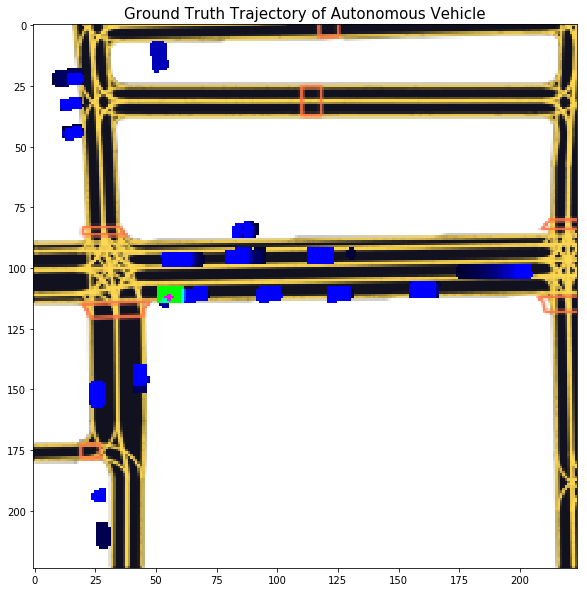

In [11]:
# cfg["raster_params"]["map_type"] = "py_semantic"

# # raster object for visualization
# rast = build_rasterizer(cfg, dm)

# # EgoDataset object
# dataset = EgoDataset(cfg, zarr_dataset, rast)

# select one example from our dataset
data = train_dataset[3670]

im = data["image"].transpose(1, 2, 0)
im = train_dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])

# plot ground truth trajectory
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR)

plt.rcParams['figure.figsize'] = 10, 10
plt.title('Ground Truth Trajectory of Autonomous Vehicle',fontsize=15)
plt.imshow(im[::-1])
plt.show()

In [15]:
im_ = data["image"]

In [16]:
im_.shape

(25, 224, 224)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:415: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))


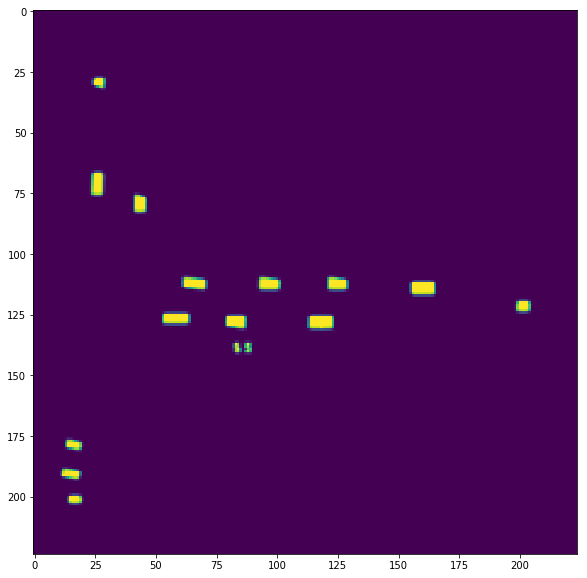

In [17]:
plt.imshow(im_[0])